# Generate Applause movies
from audio of applause and clap timing files

mov or audio
https://pythonbasics.org/python-play-sound/

https://pythonprogramming.altervista.org/animated-cartoon-gif-with-pil-and-python-1/?doing_wp_cron=1673647035.3732910156250000000000

https://www.thepythoncode.com/article/add-audio-to-video-in-python

https://stackoverflow.com/questions/48728145/video-editing-with-python-adding-a-background-music-to-a-video-with-sound

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt,find_peaks
from scipy.interpolate import interp1d
import imageio

pd.options.mode.chained_assignment = None

from matplotlib import colors
from scipy.spatial.distance import pdist, squareform
import moviepy.editor as mp
from pydub import AudioSegment
from pydub.playback import play

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
Applause_ints=pd.read_csv('data/Clapping_rounds_stats_ReCut2.csv')
#df_motion.index=(pd.to_datetime(df_motion.index))
applause_times = pd.read_csv('data/Applause_stage_events_T2.csv',sep=",") #SV alignment for beeps

# need to add datetime
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

applause_times['datetime'] = Synch_time + pd.to_timedelta(applause_times['concert_time'],'s')
#applause_times

In [16]:
general_loc = '/Users/finn/Desktop/Current_Projects/Copen/'

internal_Part = general_loc + 'Participants_internal/'

partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
# partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
partDets = partDets.loc[~partDets['X'].isna(),:]
MovingParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
Part_Codes = list(MovingParts.Participant_Code.values)
# alignedParts = MovingParts
# aligned_Part_Codes = list(alignedParts.Participant_Code.values)

In [4]:
# applause_times.loc[applause_times['Applause_N']==15,:] 

In [5]:
V =np.floor(Applause_ints.loc[:,['start_time','end_time']]/60)
pd.concat([Applause_ints['event_tag'],V,Applause_ints.loc[:,['start_time','end_time']]-60*V,Applause_ints['files']],axis=1)

,event_tag,start_time,end_time,start_time,end_time,files
0,Entre 1,-12.0,-12.0,28.80,45.9,Applause_1_entre_1_peaks.csv
1,Speech 1,-10.0,-10.0,44.10,51.4,Applause_2_speech_1_peaks.csv
2,Speech 2,0.0,0.0,30.60,40.1,Applause_3_speech_2_peaks.csv
3,Beethoven,26.0,27.0,50.60,32.1,Applause_4_beethoven_peaks.csv
4,Entre 2,33.0,33.0,24.80,36.1,Applause_5_entre_2_peaks.csv
5,Schnittke,54.0,55.0,42.60,42.7,Applause_6_schnittke_peaks.csv
6,Entre 3,83.0,83.0,21.92,39.5,Applause_7_entre_3_peaks.csv
7,Bach,100.0,100.0,20.10,42.1,Applause_8_bach_peaks.csv
8,Folk 1,112.0,112.0,39.10,56.2,Applause_9_folk_1_peaks.csv
9,Folk 2,115.0,115.0,33.40,52.6,Applause_10_folk_2_peaks.csv


In [6]:
claps_folder = '/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping/out_claps/clapping_peaks/'
sound_folder = '/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/Cl_Coordination/Clapping_Coordination/sound/'

In [7]:
# claps_folder = 'C:/Users/finnu/dev/copenhagen-musiclab-clapping/clapfiles/clapping_peaks/'
Clap_files = os.listdir(claps_folder)
clap_n = 6
clapname = 'Schnittke'#Clap_files[8]
# 6 finale, 14 schnittke, 1 beethoven, 0 bach
print(clapname)

musician_times = pd.read_csv('./Data/Final_clapping_section_accelerometer/Final_Stage_events.csv',sep=",") #SV alignment for beeps
thisround = applause_times.loc[applause_times['Applause_N']==clap_n,:].reset_index(drop=True)
# TIME LABEL
cl_start = thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values
cl_end = thisround.loc[thisround['Event']=='Clapping End','concert_time'].values
cl_dur = cl_end - cl_start
musician_times = pd.DataFrame()
musician_times['TIME'] = thisround.loc[4:12,'concert_time']-cl_start
musician_times['LABEL'] = thisround['Event']
musician_times

Schnittke


,TIME,LABEL
4,2.0,Stand
5,12.0,Bow
6,17.0,Start to leave
7,22.0,Claps in synch
8,26.0,Off stage
9,37.0,Claps in synch
10,37.0,Enter hall
11,45.0,Bow
12,51.0,Bow


In [12]:
clapname = 'Applause_6_schnittke_peaks.csv'
peaks = pd.read_csv(claps_folder + clapname,index_col=0)
peaks_IDs = peaks.columns
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)

In [13]:
# build database of clapping behaviour over measured intervals
t_interval = 1
sampletimes = np.arange(0,cl_dur-t_interval,0.2)
cols = df_OnlyClaps.columns
Clap_Feats = pd.DataFrame(index = sampletimes,columns = cols)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    these_claps = pd.Series(index = cols,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.iloc[:5]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26,NaN,NaN


In [17]:
ClapDets=partDets.loc[partDets['Participant_Code'].isin(Clap_Feats.columns),:]
#Clap_Feats = Clap_Feats[ClapDets['Participant_Code']]
Clap_Feats.fillna(0,inplace = True)
#Clap_Feats

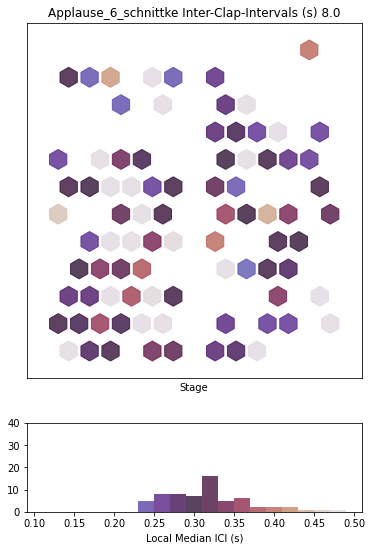

In [19]:
slice_i = 40
vmin=0.11
vmax=0.51
bins = np.arange(vmin,vmax,0.02)
colours = 'twilight'
cm = plt.cm.get_cmap(colours)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# We'll color code by height, but you could use any scalar
fracs = bins / bins.max()
col = bin_centers - min(bin_centers)
col /= max(col)

fig, ax = plt.subplots(2, 1, figsize = (6,9),gridspec_kw={'height_ratios': [4, 1]})

ax[0].scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[slice_i,:].values, cmap=colours, vmin=vmin, vmax=vmax, s=400, marker="h", alpha=0.8)
ax[0].set_xlim([-8,8])
ax[0].set_ylim([0,13])
# ax[0].set_xlim([-7,7])
# ax[0].set_ylim([0.5,12.5])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('Stage')
ax[0].set_title(clapname[:-10] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))

# N is the count in each bin, bins is the lower-limit of the bin
n, bins, patches = ax[1].hist(Clap_Feats.iloc[slice_i,:].values,bins,alpha=0.8)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
ax[1].set_xlabel('Local Median ICI (s)')
ax[1].set_ylim([0,40])
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

In [24]:
# generate gif with this 
filenames = []
vmin=0.11
vmax=0.51
bins = np.arange(vmin,vmax,0.02)
colours = 'twilight'
cm = plt.cm.get_cmap(colours)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# We'll color code by height, but you could use any scalar
fracs = bins / bins.max()
col = bin_centers - min(bin_centers)
col /= max(col)

slice_i = 0

fig, ax = plt.subplots(2, 1, figsize = (6,9),gridspec_kw={'height_ratios': [4, 1]})

ax[0].scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[slice_i,:].values, cmap=colours, vmin=vmin, vmax=vmax, s=400, marker="h", alpha=0.6)
ax[0].set_xlim([-8,8])
ax[0].set_ylim([0,13])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel('Audience')
ax[0].set_xlabel('Stage')
ax[0].set_title(clapname[:-10] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))

# N is the count in each bin, bins is the lower-limit of the bin
n, bins, patches = ax[1].hist(Clap_Feats.iloc[slice_i,:].values,bins,alpha=0.6)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
ax[1].set_xlabel('Local Median ICI (s)')
ax[1].set_ylim([0,40])
ax[1].set_title('Distribution of ICI at ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))
# create file name and append it to a list
filename = f'{slice_i}.png'
filenames.append(filename)
filenames.append(filename)

# save frame
plt.savefig(filename,bbox_inches = 'tight',dpi=200)
plt.close()

for slice_i in range(1,len(Clap_Feats)):
    fig, ax = plt.subplots(2, 1, figsize = (6,9),gridspec_kw={'height_ratios': [4, 1]})

    ax[0].scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[slice_i,:].values, cmap=colours, vmin=vmin, vmax=vmax, s=400, marker="h", alpha=0.6)
    ax[0].set_xlim([-8,8])
    ax[0].set_ylim([0,12])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_ylabel('Audience')
    ax[0].set_xlabel('Stage')
    ax[0].set_title(clapname[:-10] + ' Inter-Clap-Intervals (s) ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))

    # N is the count in each bin, bins is the lower-limit of the bin
    n, bins, patches = ax[1].hist(Clap_Feats.iloc[slice_i,:].values,bins,alpha=0.6)
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    ax[1].set_xlabel('Local Median ICI (s)')
    ax[1].set_ylim([0,40])
    ax[1].set_title('Distribution of ICI at ' + str(np.round(Clap_Feats.iloc[slice_i,:].name,2)))
    # create file name and append it to a list
    filename = f'{slice_i}.png'
    filenames.append(filename)
    filenames.append(filename)
    # save frame
    plt.savefig(filename,bbox_inches = 'tight',dpi=200)
    plt.close()
# extend the last image before looping
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)

# build gif
gif_path = './plots/Clapping_'+clapname[:-10]+'_ICI_5hz_hist.gif'
with imageio.get_writer(gif_path, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [23]:
clapname[:-10]

'Applause_6_schnittke'

In [25]:


song = AudioSegment.from_wav("sound/schnittke_claps.wav")
play(song)

In [ ]:
outfile = './plots/Clapping_Applause_6_schnittke_ICI_5hz_hist.gif'
clip = mp.VideoFileClip(outfile)
clip.write_videofile("myvideo.mp4")

t:   2%|▏         | 9/597 [00:00<00:06, 87.57it/s, now=None]

Moviepy - Building video myvideo.mp4.
Moviepy - Writing video myvideo.mp4



t:  85%|████████▍ | 506/597 [00:05<00:01, 82.63it/s, now=None]

In [ ]:
audio = mp.AudioFileClip("beethoven_claps.mp3")
video1 = mp.VideoFileClip('myvideo.mp4')
final = video1.set_audio(audio)

final.write_videofile("output.mp4")